In [1]:
import importlib
import xarray as xr
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from math import nan
import math
import datetime as dt
from glob import glob
import datetime as dt
from matplotlib import colors
import matplotlib.patches as mpatches
import itertools

import metpy.calc as mpcalc
from metpy.units import units
import metpy


from CASutils import mapplot_utils as maps
from CASutils import filter_utils as filt 

from cmocean import cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

importlib.reload(maps)
importlib.reload(filt)

<module 'CASutils.filter_utils' from '/home/dhruv/CASanalysis/CASutils/filter_utils.py'>

In [2]:
pink_lat, pink_lon = 30.039801, 360-103.657009
red_lat, red_lon = 56.246885, 360-111.578816
lblue_lat, lblue_lon = 48.333714, 360-99.442510
dblue_lat, dblue_lon = 35.032930, 360-116.383111

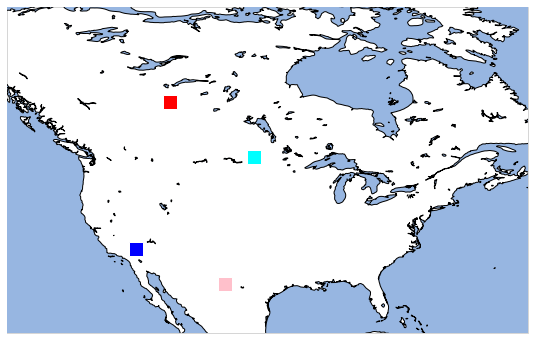

In [79]:
c_lat, c_lon = 32.032930, -114.383111

extent = [-135, -60, 23, 70]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

ax.set_extent(extent, crs=ccrs.PlateCarree())

ax.add_patch(mpatches.Rectangle(xy=[pink_lon-1, pink_lat-1], width=2, height=2, 
                                facecolor='pink', alpha=1, transform=ccrs.PlateCarree()))

ax.add_patch(mpatches.Rectangle(xy=[red_lon-1, red_lat-1], width=2, height=2, 
                                facecolor='red', alpha=1, transform=ccrs.PlateCarree()))

ax.add_patch(mpatches.Rectangle(xy=[lblue_lon-1, lblue_lat-1], width=2, height=2, 
                                facecolor='cyan', alpha=1, transform=ccrs.PlateCarree()))

ax.add_patch(mpatches.Rectangle(xy=[dblue_lon-1, dblue_lat-1], width=2, height=2, 
                                facecolor='blue', alpha=1, transform=ccrs.PlateCarree()))

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
ax.add_feature(cfeature.LAKES, edgecolor='black')

plt.show()

In [3]:
def jja_std_anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    jja_std = anoms.sel(time=anoms['time.season']=='JJA').std()
    std_anoms = anoms/jja_std
    return std_anoms

In [4]:
def anoms(data):
    data = data.sel(time=~((data.time.dt.month==2) & (data.time.dt.day == 29)))
    daystr = xr.DataArray(data.indexes['time'].strftime('%m-%d'), coords = data.time.coords, name="daystr")
    datseason = data.groupby(daystr).mean('time')
    harmonics = filt.calc_season_nharm(datseason, 4, dimtime=0)
    anoms = data.groupby(daystr)-harmonics
    return anoms

In [5]:
def remove_time_mean(x):
    return(x - x.mean(dim='time'))

def remove_annual_cycle(x):
    return x.groupby('time.year').map(remove_time_mean)

In [6]:
ps_files = ["/home/data/ERA5/PS_day/ps_{}.nc".format(i) for i in range(1979, 2020)]
ps = xr.open_mfdataset(ps_files)

In [7]:
t_files = glob('/home/dhruv/data/temp_ps/*/*.nc')
t = xr.open_mfdataset(t_files)
t

,Array,Chunk
Bytes,81.44 GB,161.91 MB
Shape,"(12, 15341, 192, 288)","(1, 366, 192, 288)"
Count,2016 Tasks,504 Chunks
Type,float64,numpy.ndarray


In [8]:
t2m_files = ["/home/data/ERA5/day/T2m_day/t2m_{}.nc".format(i) for i in range(1979, 2020)]
t2m = xr.open_mfdataset(t2m_files).load()

In [9]:
levels = t.level.data
levels

array([ 700.,  750.,  775.,  800.,  825.,  850.,  875.,  900.,  925.,
        950.,  975., 1000.])

In [10]:
def vertical_profile_box_std(t2m, t, ps, title="",five_day_prev=False):
    t2m_data = t2m.t2m.mean(dim=('lat','lon'))
    t2m_anoms = remove_annual_cycle(jja_std_anoms(t2m_data))
    jja_t2m_anoms = t2m_anoms.sel(time=t2m_anoms['time.season']=='JJA')
    heatwave_days = jja_t2m_anoms[jja_t2m_anoms>=jja_t2m_anoms.quantile(0.90)].time.values
    print('here')
    if five_day_prev:
        heatwave_days = heatwave_days - np.timedelta64(5,'D')

    arr1,arr2 = t2m.lat.data, t2m.lon.data
    combos = []
    for i in range(len(arr1)):
        for j in range(len(arr2)):
            combos.append([arr1[i],arr2[j]])
            
    num = len(combos)


    temperatures = []
    for i in range(num):
        lat = combos[i][0]
        lon = combos[i][1]
        t2m_data = t2m.t2m.sel(lat=lat,lon=lon)
        t2m_anoms2 = remove_annual_cycle(jja_std_anoms(t2m_data))
        temperatures.append(t2m_anoms2.sel(time=heatwave_days).mean().compute().item())
        
            
            
    surface_pressure = []
    for i in range(num):
        lat = combos[i][0]
        lon = combos[i][1]
        surface_pressure.append(ps.ps.sel(lat=lat,lon=lon).mean().compute().item()/100)
        
  
    colors = ['blue','violet','red','grey','dodgerblue','cyan',
             'lime', 'yellow', 'orange','black','peru','mediumpurple']
    
    for i in range(num):
        vert_profile = dict()
        for level in levels:
            print(level)
            t_level = t.sel(level=level,lat =combos[i][0] , lon = combos[i][1])
            try:
                t_level_anoms = remove_annual_cycle(jja_std_anoms(t_level.T))
                vert_profile[level] = t_level_anoms.sel(time=heatwave_days).mean().item()
            except: 
                vert_profile[level] = nan

            
            dele = []
            for key in vert_profile.keys():
                if key > surface_pressure[i]:
                    dele.append(key) 
   
            for key in dele:
                del vert_profile[key]
                vert_profile[key] = np.nan
      
        print(i)
        plt.plot(vert_profile.values(), vert_profile.keys() , color=colors[i])
        
#     for level in levels:
#         print(level)
#         t_level = t.sel(level=level).mean(dim=('lat','lon'))
#         try:
#             t_level_anoms = remove_annual_cycle(jja_std_anoms(t_level.T))
#             vert_profile[level] = t_level_anoms.sel(time=heatwave_days).mean().item()
#         except: 
#             vert_profile[level] = nan
            
#     hpa_levs = []
#     temp_levs = []
#     for i in sorted (vert_profile) :
#         hpa_levs.append(i)
#         temp_levs.append(vert_profile[i])

#     plt.plot(temp_levs, hpa_levs , color="black")
    plt.scatter(temperatures, surface_pressure, color=colors)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show() 

In [11]:
t2m_salmon = t2m.loc[dict(lat=slice((pink_lat-2), (pink_lat+2)), lon = slice(pink_lon-2, pink_lon+2))]
t_salmon = t.loc[dict(lat=slice((pink_lat-2), (pink_lat+2)), lon = slice(pink_lon-2, pink_lon+2))].load()
ps_salmon = ps.loc[dict(lat=slice((pink_lat-2), (pink_lat+2)), lon = slice(pink_lon-2, pink_lon+2))].load()

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0


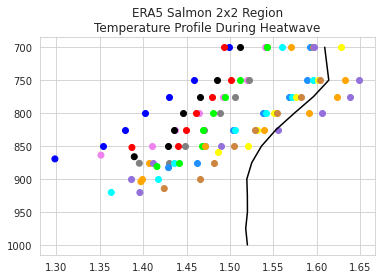

In [95]:
vertical_profile_box_std(t2m_salmon, t_salmon, ps_salmon, five_day_prev=False,
                      title='ERA5 Salmon 2x2 Region\nTemperature Profile During Heatwave')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11


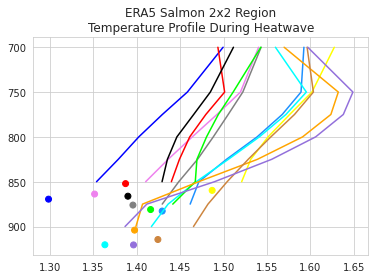

In [12]:
#corrected
vertical_profile_box_std(t2m_salmon, t_salmon, ps_salmon, five_day_prev=False,
                      title='ERA5 Salmon 2x2 Region\nTemperature Profile During Heatwave')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0


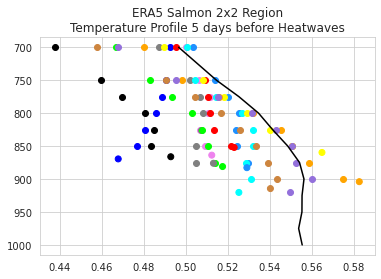

In [96]:
vertical_profile_box_std(t2m_salmon, t_salmon, ps_salmon, five_day_prev=True,
                      title='ERA5 Salmon 2x2 Region\nTemperature Profile 5 days before Heatwaves')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11


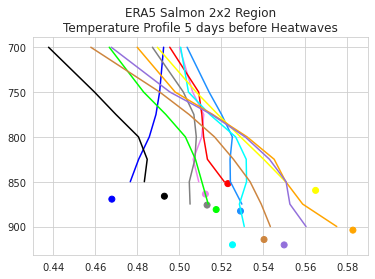

In [13]:
vertical_profile_box_std(t2m_salmon, t_salmon, ps_salmon, five_day_prev=True,
                      title='ERA5 Salmon 2x2 Region\nTemperature Profile 5 days before Heatwaves')

In [14]:
t2m_red = t2m.loc[dict(lat=slice((red_lat-2), (red_lat+2)), lon = slice(red_lon-2, red_lon+2))]
t_red = t.loc[dict(lat=slice((red_lat-2), (red_lat+2)), lon = slice(red_lon-2, red_lon+2))].load()
ps_red = ps.loc[dict(lat=slice((red_lat-2), (red_lat+2)), lon = slice(red_lon-2, red_lon+2))].load()

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0


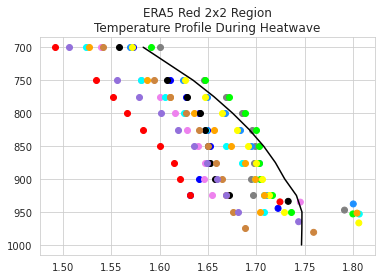

In [98]:
vertical_profile_box_std(t2m_red, t_red, ps_red, five_day_prev=False,
                      title='ERA5 Red 2x2 Region\nTemperature Profile During Heatwave')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11


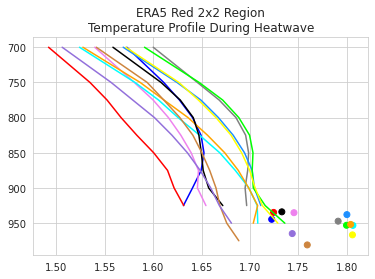

In [15]:
vertical_profile_box_std(t2m_red, t_red, ps_red, five_day_prev=False,
                      title='ERA5 Red 2x2 Region\nTemperature Profile During Heatwave')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0


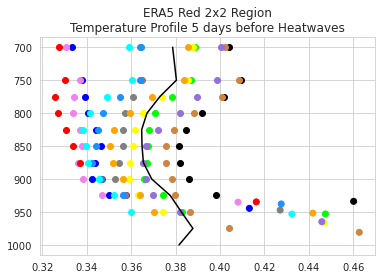

In [99]:
vertical_profile_box_std(t2m_red, t_red, ps_red, five_day_prev=True,
                      title='ERA5 Red 2x2 Region\nTemperature Profile 5 days before Heatwaves')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11


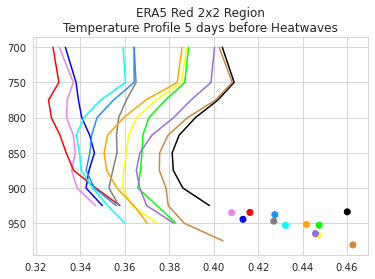

In [16]:
vertical_profile_box_std(t2m_red, t_red, ps_red, five_day_prev=True,
                      title='ERA5 Red 2x2 Region\nTemperature Profile 5 days before Heatwaves')

In [17]:
t2m_lblue = t2m.loc[dict(lat=slice((lblue_lat-2), (lblue_lat+2)), lon = slice(lblue_lon-2, lblue_lon+1))]
t_lblue = t.loc[dict(lat=slice((lblue_lat-2), (lblue_lat+2)), lon = slice(lblue_lon-2, lblue_lon+1))].load()
ps_lblue = ps.loc[dict(lat=slice((lblue_lat-2), (lblue_lat+2)), lon = slice(lblue_lon-2, lblue_lon+1))].load()

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0


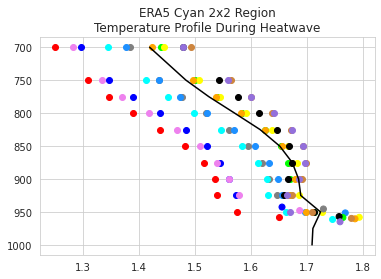

In [112]:
vertical_profile_box_std(t2m_lblue, t_lblue, ps_lblue, five_day_prev=False,
                      title='ERA5 Cyan 2x2 Region\nTemperature Profile During Heatwave')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11


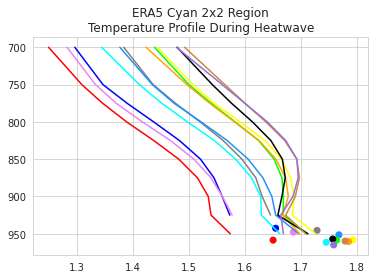

In [18]:
vertical_profile_box_std(t2m_lblue, t_lblue, ps_lblue, five_day_prev=False,
                      title='ERA5 Cyan 2x2 Region\nTemperature Profile During Heatwave')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0


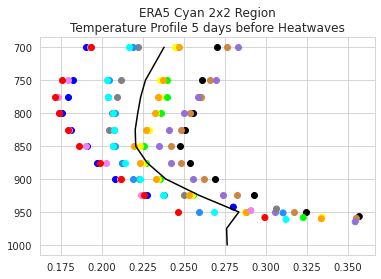

In [113]:
vertical_profile_box_std(t2m_lblue, t_lblue, ps_lblue, five_day_prev=True,
                      title='ERA5 Cyan 2x2 Region\nTemperature Profile 5 days before Heatwaves')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11


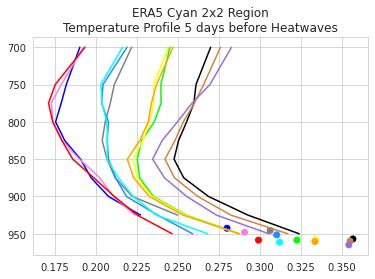

In [19]:
vertical_profile_box_std(t2m_lblue, t_lblue, ps_lblue, five_day_prev=True,
                      title='ERA5 Cyan 2x2 Region\nTemperature Profile 5 days before Heatwaves')

In [20]:
t2m_dblue = t2m.loc[dict(lat=slice((dblue_lat-2), (dblue_lat+2)), lon = slice(dblue_lon-2, dblue_lon+2))]
t_dblue = t.loc[dict(lat=slice((dblue_lat-2), (dblue_lat+2)), lon = slice(dblue_lon-2, dblue_lon+2))].load()
ps_dblue = ps.loc[dict(lat=slice((dblue_lat-2), (dblue_lat+2)), lon = slice(dblue_lon-2, dblue_lon+2))].load()

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0


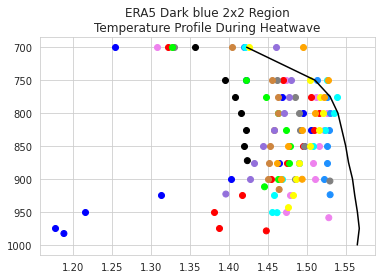

In [115]:
vertical_profile_box_std(t2m_dblue, t_dblue, ps_dblue, five_day_prev=False,
                      title='ERA5 Dark blue 2x2 Region\nTemperature Profile During Heatwave')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11


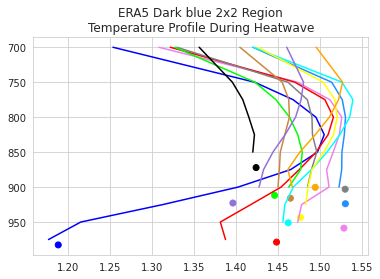

In [21]:
vertical_profile_box_std(t2m_dblue, t_dblue, ps_dblue, five_day_prev=False,
                      title='ERA5 Dark blue 2x2 Region\nTemperature Profile During Heatwave')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0


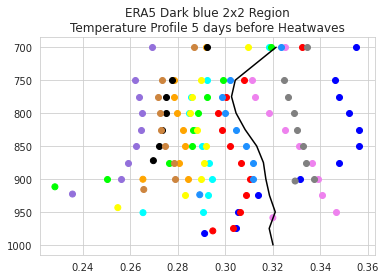

In [116]:
vertical_profile_box_std(t2m_dblue, t_dblue, ps_dblue, five_day_prev=True,
                      title='ERA5 Dark blue 2x2 Region\nTemperature Profile 5 days before Heatwaves')

here
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
0
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
1
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
2
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
3
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
4
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
5
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
6
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
7
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
8
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
9
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
10
700.0
750.0
775.0
800.0
825.0
850.0
875.0
900.0
925.0
950.0
975.0
1000.0
11


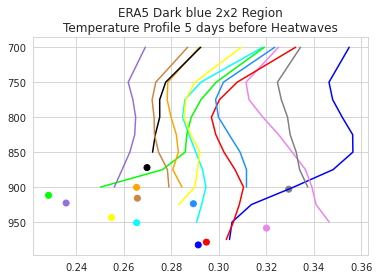

In [22]:
vertical_profile_box_std(t2m_dblue, t_dblue, ps_dblue, five_day_prev=True,
                      title='ERA5 Dark blue 2x2 Region\nTemperature Profile 5 days before Heatwaves')